In [109]:
import kagglehub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16, vgg19, resnet50
from tensorflow.python.eager import context
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import time
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

_ = tf.Variable([1])

context._context = None
context._create_context()

# Включить все возможные оптимизации
tf.config.optimizer.set_jit(True)  # XLA
tf.config.threading.set_inter_op_parallelism_threads(8)
tf.config.threading.set_intra_op_parallelism_threads(8)

# Mixed Precision + AutoCast
policy = tf.keras.mixed_precision.Policy('mixed_float16')  # Для NVIDIA/TPU
tf.keras.mixed_precision.set_global_policy(policy)

In [50]:
print("Загрузка датасета...")
dataset_path = kagglehub.dataset_download("tanlikesmath/the-oxfordiiit-pet-dataset")
images_dir = os.path.join(dataset_path, "images")
print(f"Количество изображений: {len(os.listdir(images_dir))}")

Загрузка датасета...
Количество изображений: 7394


глобальные константы

In [12]:
IMG_SIZE = 160
EPOCHS = 15
BATCH_SIZE = 256
BUFFER_SIZE = tf.data.AUTOTUNE
SEED = 42
TEST_SPLIT_RATIO = 0.2
VAL_SPLIT_RATIO = 0.2

пишем вспомогательные функции

In [13]:
from enum import Enum
Animal = Enum('Animal', [('CAT', 1), ('DOG', 0)])
Model = Enum('Model', [('VGG16', 'vgg16'), ('VGG19', 'vgg19'), ('RESNET50', 'resnet50')])

name_to_model_map = {
  'vgg16': tf.keras.applications.vgg16,
  'vgg19': tf.keras.applications.vgg19,
  'resnet50': tf.keras.applications.resnet50,
}

image_paths = []
breed_labels = []
species_labels = []
breeds = set()
skipped_files = 0
processed_files = 0

def get_species(filename, is_filename_a_breed = False):
    breed = getattr(re.match(r'^([A-Za-z_]+)_\d+\.jpg$', filename), 'group', lambda _: '')(1) if not is_filename_a_breed else filename
    if not breed:
      return None
    return Animal.CAT if breed[0].isupper() else Animal.DOG


def create_dataset(image_paths, labels, model_name, is_training=True):
    dataset = \
      tf.data.Dataset.from_tensor_slices((
          tf.constant(image_paths, dtype=tf.string),
          tf.constant(labels, dtype=tf.int32)
      )).map(
          lambda x, y: preprocess_image(x, y, model_name),
          num_parallel_calls=tf.data.AUTOTUNE
      )

    if is_training:
        data_augmentation = tf.keras.Sequential([
          layers.RandomFlip("horizontal", seed=SEED),
          layers.RandomRotation(0.12, seed=SEED),
          layers.RandomZoom(0.12, seed=SEED),
          layers.RandomContrast(0.12, seed=SEED),
        ], name="data_augmentation")

        dataset = dataset \
          .shuffle(buffer_size=len(image_paths), seed=SEED)\
          .map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
          )

    return dataset \
      .batch(BATCH_SIZE, drop_remainder=(is_training)) \
      .prefetch(buffer_size=tf.data.AUTOTUNE)

def preprocess_image(image_path, label, model_name):
    try:
        img_string = tf.io.read_file(image_path)
        img = tf.image.decode_image(img_string, channels=3, expand_animations=False)
    except Exception as e:
        img = tf.zeros([IMG_SIZE, IMG_SIZE, 3], dtype=tf.float32)

    img.set_shape([None, None, 3])
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = name_to_model_map[model_name].preprocess_input(img)

    return img, label

обрабатываем файлы

In [14]:
print(f"Всего файлов: {len(os.listdir(images_dir))}")

for filename in os.listdir(images_dir):
    if os.path.isdir(os.path.join(images_dir, filename)):
        skipped_files += 1
        continue

    breed = getattr(re.match(r'^([A-Za-z_]+)_\d+\.jpg$', filename), 'group', lambda _: '')(1)
    species = get_species(filename)

    if breed is None or species is None:
        skipped_files += 1
        continue

    image_paths.append(os.path.join(images_dir, filename))
    breed_labels.append(breed)
    species_labels.append(species)
    breeds.add(breed)
    processed_files += 1


print(f"Обработано {processed_files} файлов")
print(f"Пропущено {skipped_files} файлов")

Всего файлов: 7394
Обработано 7390 файлов
Пропущено 4 файлов


получаем названия пород и конвертируем их в числовые значения

In [15]:
sorted_breeds = sorted(list(breeds))
breed_to_id_map = {name: i for i, name in enumerate(sorted_breeds)}
id_to_breed_map = {i: name for name, i in breed_to_id_map.items()}

print(f"\nНайдено {len(breed_to_id_map)} пород.")

# Переводим породы из текста в id
all_breed_ids = [breed_to_id_map[breed] for breed in breed_labels]


Найдено 37 пород.


разделяем данные

In [13]:
train_val_paths, test_image_paths, train_val_breed_ids, test_breed_ids, train_val_species, test_species = \
train_test_split(
    image_paths,
    all_breed_ids,
    species_labels,
    test_size=TEST_SPLIT_RATIO,
    random_state=SEED,
    stratify=all_breed_ids
)

y_true_breed_test = np.array(test_breed_ids)
y_true_species_test = np.array(test_species)

train_image_paths, val_image_paths, train_breed_ids, val_breed_ids, train_species, val_species = \
train_test_split(
    train_val_paths,
    train_val_breed_ids,
    train_val_species,
    test_size=VAL_SPLIT_RATIO,
    random_state=SEED,
    stratify=train_val_breed_ids
)

print(f"Всего изображений: {len(image_paths)}")
print(f"Размер тестовой выборки: {len(test_image_paths)}")
print(f"Размер обучающей выборки: {len(train_image_paths)}")
print(f"Размер валидационной выборки: {len(val_image_paths)}")

Всего изображений: 7390
Размер тестовой выборки: 1478
Размер обучающей выборки: 4729
Размер валидационной выборки: 1183


создание моделей

In [ ]:
def build_transfer_model(name, classes_count, input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    model_from_enum = name_to_model_map[name]
    base_model = model_from_enum.__dict__[name.upper() if name != Model.RESNET50.value else 'ResNet50'](weights='imagenet', include_top=False, pooling='avg')
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        base_model,
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(classes_count, activation='softmax', dtype='float32')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')
        ]
    )
    return model

Обучение моделей




  Обучение модели vgg16, начало: 1747075809.9956534 



Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.0264 - loss: 13.1041 - top_3_accuracy: 0.0868 - top_5_accuracy: 0.1444 - val_accuracy: 0.1216 - val_loss: 14.3107 - val_top_3_accuracy: 0.2706 - val_top_5_accuracy: 0.3615
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 138s 5s/step - accuracy: 0.0592 - loss: 9.9303 - top_3_accuracy: 0.1550 - top_5_accuracy: 0.2301 - val_accuracy: 0.2146 - val_loss: 10.8596 - val_top_3_accuracy: 0.3911 - val_top_5_accuracy: 0.5148
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step - accuracy: 0.1013 - loss: 8.0450 - top_3_accuracy: 0.2375 - top_5_accuracy: 0.3176 - val_accuracy: 0.2822 - val_loss: 8.9772 - val_top_3_accuracy: 0.4968 - val_top_5_accuracy: 0.6448
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step - accuracy: 0.1362 - loss: 6.7850 - top_3_accuracy: 0.2923 - top_5_accuracy: 0.3983 - val_accuracy: 0.3319 - val_loss: 8.0242 - val_top_3_accuracy: 0.5962 - val_top_5_accuracy: 0.727

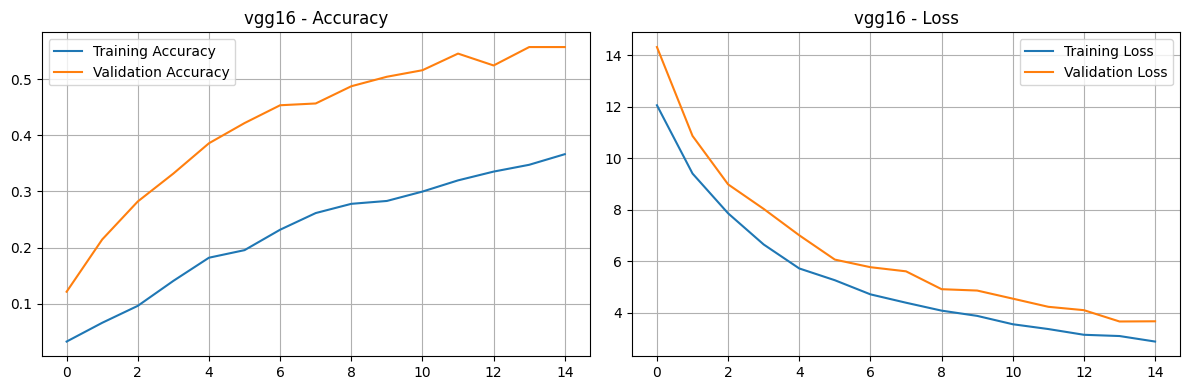




  Обучение модели vgg19, начало: 1747078104.450608 



Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 196s 7s/step - accuracy: 0.0271 - loss: 12.0248 - top_3_accuracy: 0.0861 - top_5_accuracy: 0.1575 - val_accuracy: 0.0793 - val_loss: 15.9098 - val_top_3_accuracy: 0.1966 - val_top_5_accuracy: 0.2865
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 200s 7s/step - accuracy: 0.0670 - loss: 9.0670 - top_3_accuracy: 0.1560 - top_5_accuracy: 0.2365 - val_accuracy: 0.1501 - val_loss: 11.8607 - val_top_3_accuracy: 0.3446 - val_top_5_accuracy: 0.4662
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 199s 7s/step - accuracy: 0.0975 - loss: 7.6285 - top_3_accuracy: 0.2140 - top_5_accuracy: 0.3093 - val_accuracy: 0.2463 - val_loss: 9.3113 - val_top_3_accuracy: 0.4567 - val_top_5_accuracy: 0.5888
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 191s 7s/step - accuracy: 0.1219 - loss: 6.6260 - top_3_accuracy: 0.2740 - top_5_accuracy: 0.3740 - val_accuracy: 0.3055 - val_loss: 7.5237 - val_top_3_accuracy: 0.5497 - val_top_5_accuracy: 0.6776

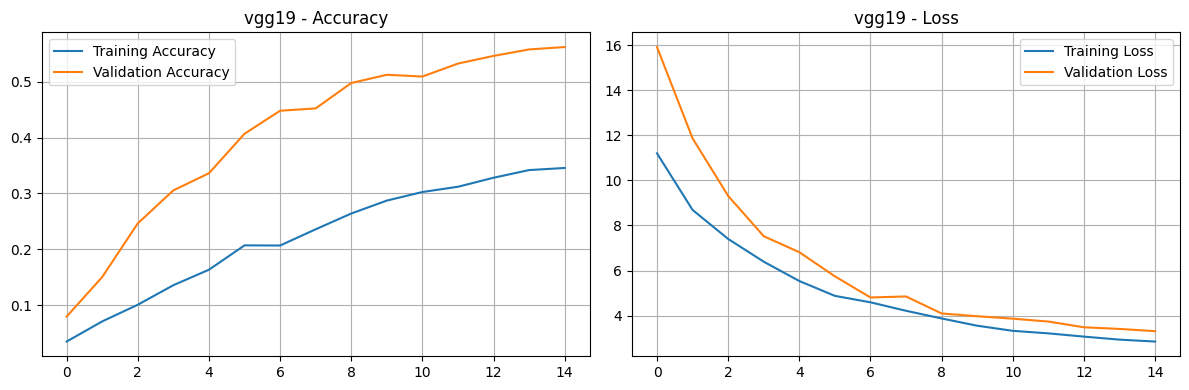




  Обучение модели resnet50, начало: 1747080955.0298285 



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 71s 1us/step
Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.0669 - loss: 4.7996 - top_3_accuracy: 0.1531 - top_5_accuracy: 0.2363 - val_accuracy: 0.4397 - val_loss: 1.9463 - val_top_3_accuracy: 0.6956 - val_top_5_accuracy: 0.8182
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.2847 - loss: 2.8392 - top_3_accuracy: 0.5004 - top_5_accuracy: 0.6242 - val_accuracy: 0.5729 - val_loss: 1.3838 - val_top_3_accuracy: 0.8383 - val_top_5_accuracy: 0.9133
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.3807 - loss: 2.3322 - top_3_accuracy: 0.6302 - top_5_accuracy: 0.7395 - val_accuracy: 0.6628 - val_loss: 1.0943 - val_top_3_accuracy: 0.8901 - val_top_5_accuracy: 0.9450
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.4190 - loss: 2.1520 - top_3_accuracy: 0.6467 - top_5_accuracy: 0.7552 - val_accuracy: 0.7030 - val_loss: 0.9679 - val_to

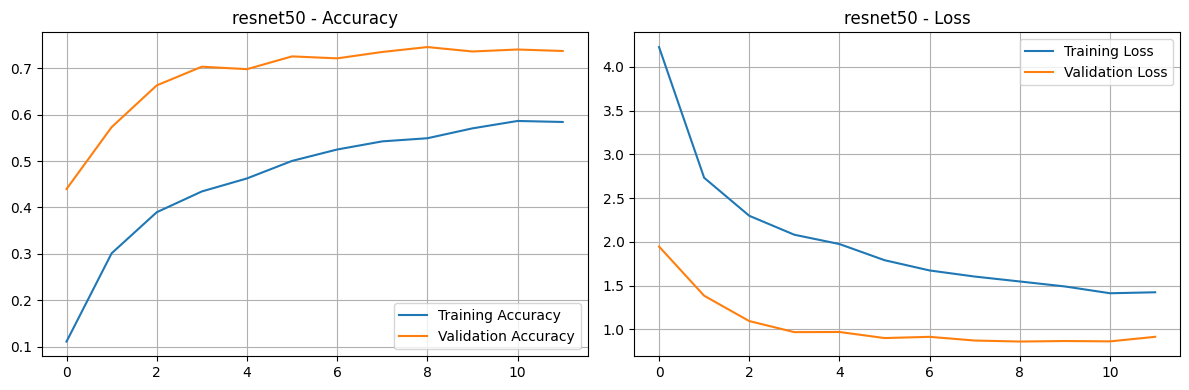

In [28]:
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


histories = {}
models = {}
classes_count = len(breed_to_id_map)

for model_name in [e.value for e in Model]:
    start_time = time.time()
    print(f"\n\n\n  Обучение модели {model_name}, начало: {start_time} \n\n\n")

    train_ds = create_dataset(train_image_paths, train_breed_ids, model_name, is_training=True)

    temp_paths = np.array(train_image_paths)
    temp_labels = np.array(train_breed_ids)
    indices = np.arange(len(temp_paths))
    np.random.seed(SEED)
    np.random.shuffle(indices)
    temp_paths = temp_paths[indices]
    temp_labels = temp_labels[indices]

    split_index = int(len(temp_paths) * (1 - TEST_SPLIT_RATIO))
    sub_train_paths = temp_paths[:split_index].tolist()
    sub_train_labels = temp_labels[:split_index].tolist()
    val_paths = temp_paths[split_index:].tolist()
    val_labels = temp_labels[split_index:].tolist()

    train_ds = create_dataset(sub_train_paths, sub_train_labels, model_name, is_training=True)
    val_ds = create_dataset(val_paths, val_labels, model_name, is_training=False)
    test_ds = create_dataset(test_image_paths, test_breed_ids, model_name, is_training=False)

    model = build_transfer_model(model_name, classes_count)

    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=val_ds,
        callbacks=[
          tf.keras.callbacks.EarlyStopping(
              monitor='val_accuracy',
              verbose=1,
              patience=3,
              restore_best_weights=True
          ),
          tf.keras.callbacks.ModelCheckpoint(
              monitor='val_accuracy',
              filepath=f'{model_name}_checkpoint.keras',
              save_best_only=True
          )
        ],
        verbose=1,
    )

    histories[model_name] = history
    models[model_name] = model

    end_time = time.time()
    print(f"Обучение {model_name} завершено за {end_time - start_time:.2f} секунд.")

    plot_training_history(history, model_name)

оценка моделей на тестовом наборе

In [39]:
def evaluate_model(
    model_name,
    model,
    test_image_paths,
    test_breed_ids,
    create_dataset_func
):
    test_ds = create_dataset_func(test_image_paths, test_breed_ids, model_name, is_training=False)
    eval_results = model.evaluate(test_ds, verbose=1)
    return {
        'loss': float(eval_results[0]),
        'accuracy': float(eval_results[1]),
        'top_3_accuracy': float(eval_results[2]) if len(eval_results) > 2 else None,
        'top_5_accuracy': float(eval_results[3]) if len(eval_results) > 3 else None
    }


def print_evaluation_results(metrics):
    print(f"Loss: {metrics['loss']:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Top-3 Accuracy: {metrics['top_3_accuracy']:.4f}")
    print(f"Top-5 Accuracy: {metrics['top_5_accuracy']:.4f}")


def select_best_model(results):
    best_model_name = max(
        (name for name in results if results[name] is not None),
        key=lambda name: results[name]['accuracy']
    )
    return best_model_name, models[best_model_name]


results = {}
for model_name in [e.value for e in Model]:
    print(f"\nмодель {model_name}")
    results[model_name] = evaluate_model(model_name, models[model_name], test_image_paths, test_breed_ids, create_dataset)
    print_evaluation_results(results[model_name])

best_model_name, best_model = select_best_model(results)
print(f"\nЛучшая модель - {best_model_name}")
best_model


модель vgg16
12/12 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.5408 - loss: 3.9162 - top_3_accuracy: 0.8256 - top_5_accuracy: 0.8964
Loss: 3.9218
Accuracy: 0.5284
Top-3 Accuracy: 0.8187
Top-5 Accuracy: 0.8985

модель vgg19
12/12 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - accuracy: 0.5563 - loss: 3.3321 - top_3_accuracy: 0.8253 - top_5_accuracy: 0.9027
Loss: 3.3699
Accuracy: 0.5474
Top-3 Accuracy: 0.8309
Top-5 Accuracy: 0.9039

модель resnet50
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.7382 - loss: 0.8717 - top_3_accuracy: 0.9284 - top_5_accuracy: 0.9550
Loss: 0.8964
Accuracy: 0.7273
Top-3 Accuracy: 0.9256
Top-5 Accuracy: 0.9560

Лучшая модель - resnet50


<Sequential name=sequential_4, built=True>

подробнее про лучшую модель

In [62]:
y_pred = best_model.predict(
    create_dataset(test_image_paths, test_breed_ids, best_model_name, False),
    verbose=1
)

12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step


[<Animal.CAT: 1> <Animal.DOG: 0> <Animal.CAT: 1> ... <Animal.CAT: 1>
 <Animal.DOG: 0> <Animal.DOG: 0>] [<Animal.CAT: 1> <Animal.DOG: 0> <Animal.CAT: 1> ... <Animal.CAT: 1>
 <Animal.DOG: 0> <Animal.DOG: 0>]
Бинарная точность: 0.9763

Top-k Accuracy:
Top-3: 0.9256
Top-5: 0.9560


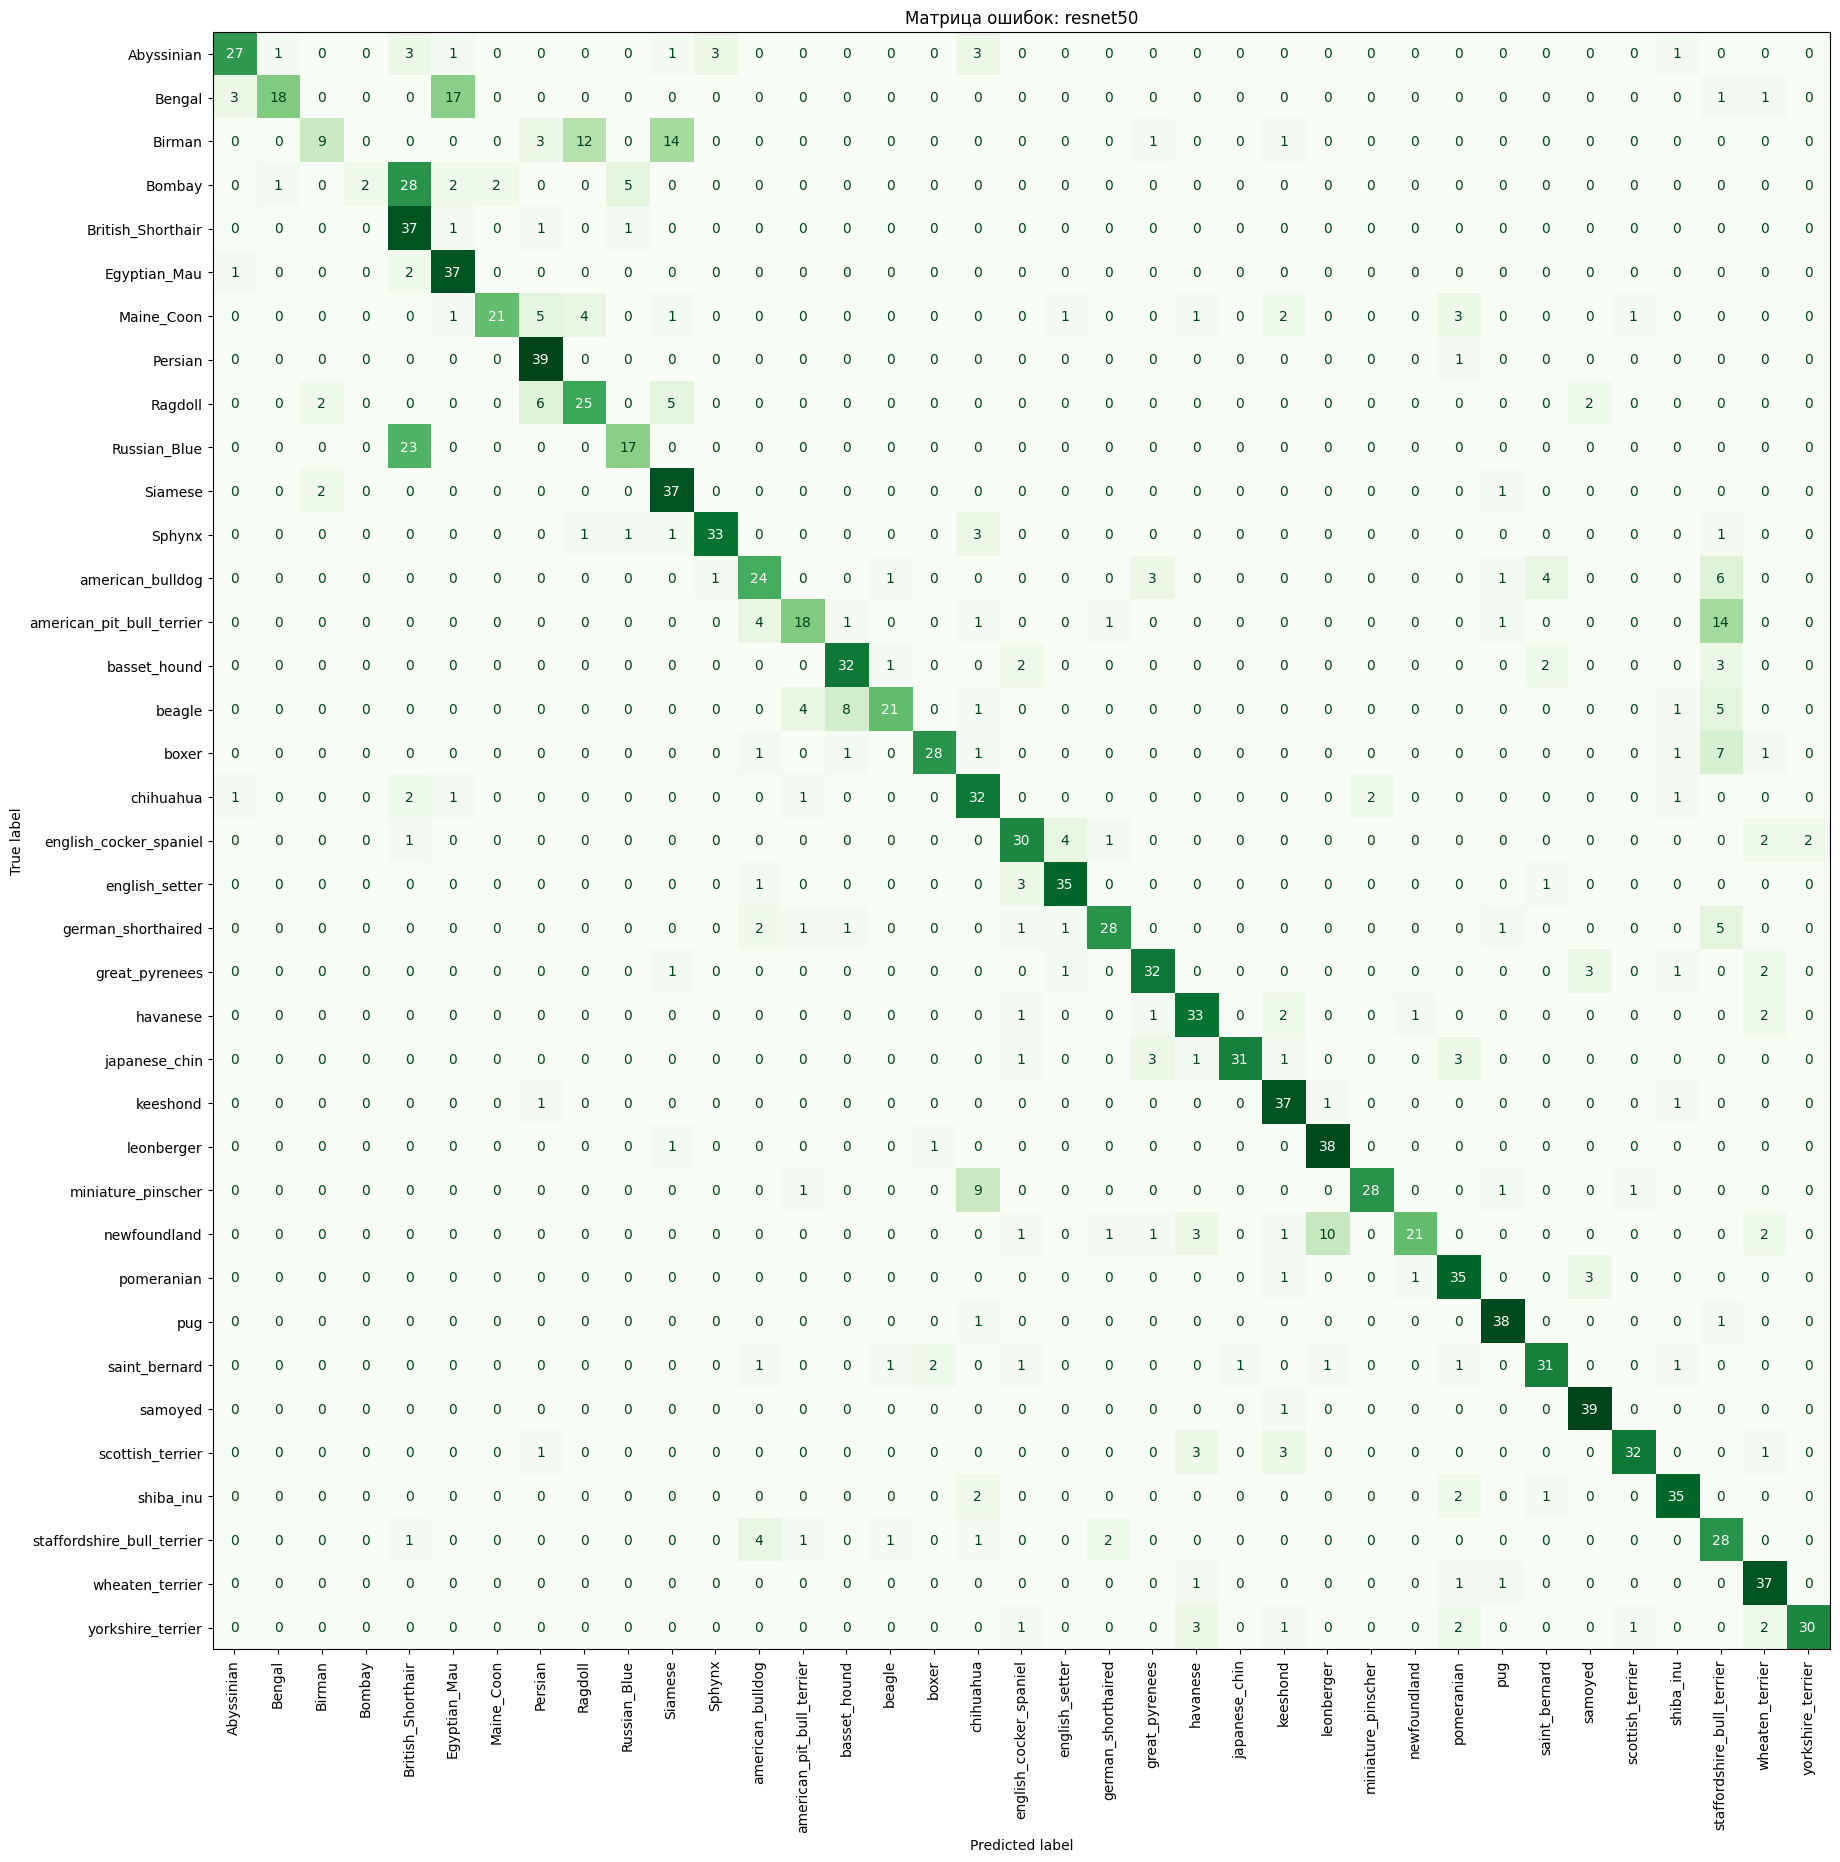

In [91]:
y_pred_breed = np.argmax(y_pred, axis=1)

breed_id_to_species = {v: get_species(k, True) for k, v in breed_to_id_map.items()}
y_pred_species = np.array([breed_id_to_species[i] for i in y_pred_breed])
print(y_true_species_test, y_pred_species)
print(f"Бинарная точность: {accuracy_score([k.value for k in y_true_species_test], [k.value for k in y_pred_species]):.4f}")

plt.figure(figsize=(classes_count * 0.7, classes_count * 0.5))
ConfusionMatrixDisplay(
    confusion_matrix(y_true_breed_test, y_pred_breed),
    display_labels=id_to_breed_map.values()
).plot(
    cmap='Greens',
    xticks_rotation=90,
    colorbar=False,
    ax=plt.gca(),
)
plt.tight_layout()
plt.title(f'Матрица ошибок: {best_model_name}')

print("\nTop-k Accuracy:")
print(f"Top-3: {results[best_model_name]['top_3_accuracy']:.4f}\nTop-5: {results[best_model_name]['top_5_accuracy']:.4f}")

Результаты GAN будут сохраняться в: gan-results
Датасет подготовлен: 7390 изображений


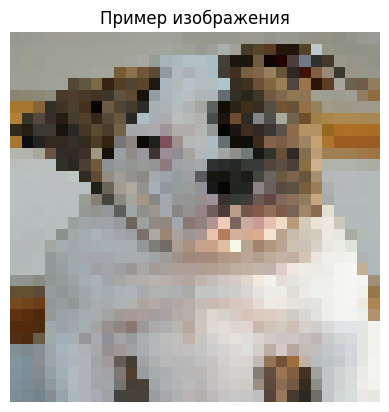

In [134]:
IMG_SIZE_GAN = 32
LATENT_DIM = 64
EPOCHS_GAN = 15
BATCH_SIZE_GAN = 64
BUFFER_SIZE_GAN = 5000
MAX_IMAGES = 2000
GAN_STORAGE = "gan-results"

if not os.path.exists(GAN_STORAGE):
    os.makedirs(GAN_STORAGE)

print(f"Результаты GAN будут сохраняться в: {GAN_STORAGE}")


def preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(tf.image.convert_image_dtype(img, tf.float32), [IMG_SIZE_GAN, IMG_SIZE_GAN])
    img = (img * 2) - 1
    return img

gan_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
gan_dataset = gan_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
gan_dataset = gan_dataset.cache()
gan_dataset = gan_dataset.shuffle(BUFFER_SIZE_GAN).batch(BATCH_SIZE_GAN).prefetch(tf.data.AUTOTUNE)

print(f"Датасет подготовлен: {len(image_paths)} изображений")
plt.imshow((next(iter(gan_dataset))[0] + 1)/2)
plt.title("Пример изображения")
plt.axis('off')
plt.show()

Создание генератора

In [135]:
def build_generator():
    inputs = keras.Input(shape=(LATENT_DIM,))
    
    x = layers.Dense(4 * 4 * 128, use_bias=False)(inputs)
    x = layers.Reshape((4, 4, 128))(x)
    
    x = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Conv2DTranspose(16, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    outputs = layers.Conv2D(3, (3, 3), padding='same', activation='tanh')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="generator")
    return model

Создание дискриминатора

In [136]:
def build_discriminator():
    inputs = keras.Input(shape=(IMG_SIZE_GAN, IMG_SIZE_GAN, 3))
    
    x = layers.Conv2D(16, (4, 4), strides=(2, 2), padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(32, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Flatten()(x)
    outputs = layers.Dense(1)(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="discriminator")
    return model

Создание функций потерь и оптимизаторов

In [137]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Еще понадобится генерация шума и функция сохранения изображений

In [138]:
def generate_random_noise(batch_size, latent_dim):
    return tf.random.normal([batch_size, latent_dim])

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        img = tf.cast((predictions[i] + 1) / 2.0, tf.float32).numpy()
        plt.imshow(img)
        plt.axis('off')
    
    plt.savefig(os.path.join(GAN_STORAGE, f'image_at_epoch_{epoch:02d}.png'))
    plt.close()

Основная функция шага обучения

In [139]:
@tf.function
def train_step(generator, discriminator, images):
    batch_size = tf.shape(images)[0]
    noise = generate_random_noise(batch_size, LATENT_DIM)
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

Основная функция обучения

In [140]:
def train_gan(dataset):
    generator = build_generator()
    discriminator = build_discriminator()
    
    seed = generate_random_noise(16, LATENT_DIM)
    start_time = time.time()
    
    best_loss = float('inf')
    patience = 10
    patience_counter = 0
    early_stop = False
    history = {
        'gen_loss': [],
        'disc_loss': [],
        'epoch_times': []
    }

    steps_per_epoch = MAX_IMAGES // BATCH_SIZE_GAN + (1 if MAX_IMAGES % BATCH_SIZE_GAN > 0 else 0)
    for epoch in range(EPOCHS_GAN):
        if early_stop:
            print(f"Раннее остановка на эпохе {epoch}")
            break
            
        epoch_start_time = time.time()
        total_gen_loss = 0
        total_disc_loss = 0
        steps = 0
        
        print(f"Начало эпохи {epoch+1}/{EPOCHS_GAN}...")
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(generator, discriminator, image_batch)
            total_gen_loss += gen_loss
            total_disc_loss += disc_loss
            steps += 1
            
            if steps % 20 == 0:
                elapsed = time.time() - epoch_start_time
                eta = (elapsed / steps) * (steps_per_epoch - steps)
                print(f'Эпоха {epoch+1}, шаг {steps}/{steps_per_epoch}, {elapsed:.1f}s, ETA: {eta:.1f}s: Gen: {gen_loss:.4f}, Disc: {disc_loss:.4f}', end='\r')
        
        avg_gen_loss = total_gen_loss / steps
        avg_disc_loss = total_disc_loss / steps
        
        epoch_time = time.time() - epoch_start_time
        history['gen_loss'].append(avg_gen_loss)
        history['disc_loss'].append(avg_disc_loss)
        history['epoch_times'].append(epoch_time)
        
        if len(history['gen_loss']) > 3:
            recent_avg = sum(history['gen_loss'][-3:]) / 3
            if recent_avg < best_loss:
                best_loss = recent_avg
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    early_stop = True
        else:
            if avg_gen_loss < best_loss:
                best_loss = avg_gen_loss
            
        print(f'Epoch {epoch+1}/{EPOCHS_GAN}, Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}, Time: {epoch_time:.2f}s')
        
        if (epoch + 1) % 3 == 0 or epoch == EPOCHS_GAN - 1 or early_stop:
            generate_and_save_images(generator, epoch + 1, seed)
    
    total_time = time.time() - start_time
    print(f'Общее время обучения: {total_time:.2f} секунд')
    print(f'Среднее время на эпоху: {total_time / (epoch + 1):.2f} секунд')
    
    try:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['gen_loss'], label='Generator')
        plt.plot(history['disc_loss'], label='Discriminator')
        plt.title('Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history['epoch_times'])
        plt.title('Epoch Times')
        plt.xlabel('Epoch')
        plt.ylabel('Time (s)')
        
        plt.tight_layout()
        plt.savefig(os.path.join(GAN_STORAGE, 'training_history.png'))
        print(f"График обучения сохранен в {os.path.join(GAN_STORAGE, 'training_history.png')}")
    except Exception as e:
        print(f"Ошибка при создании графика: {e}")
    
    try:
        model_save_path = os.path.join(GAN_STORAGE, 'generator_model.keras')
        generator.save(model_save_path)
        print(f"Модель сохранена в {model_save_path}")
    except Exception as e:
        print(f"Ошибка при сохранении модели: {e}")
        print("Продолжаем без сохранения модели")
    
    return generator

Функции для генерации и улучшения изображений

In [144]:
def generate_new_images(generator, num_images=16):
    noise = generate_random_noise(num_images, LATENT_DIM)
    generated_images = generator(noise, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        img = (generated_images[i].numpy() + 1) / 2.0
        plt.imshow(img)
        plt.axis('off')
    
    plt.savefig(os.path.join(GAN_STORAGE, 'final_generated_images.png'))
    plt.close()
    return generated_images

def enhance_and_upscale_images(generated_images, target_size=128):
    print(f"Улучшение качества изображений и повышение разрешения до {target_size}x{target_size}...")
    
    enhanced_images = []
    
    for i, img in enumerate(generated_images):
        img = (img.numpy() + 1) / 2.0
        
        upscaled = tf.image.resize(
            img, [target_size, target_size], 
            method=tf.image.ResizeMethod.BICUBIC
        ).numpy()
        
        enhanced = upscaled * 1.1
        enhanced = np.clip(enhanced, 0, 1)
        
        enhanced_images.append(enhanced)
        
        plt.figure(figsize=(5, 5))
        plt.imshow(enhanced)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(GAN_STORAGE, f'enhanced_image_{i + 1}.png'), bbox_inches='tight', pad_inches=0.1)
        plt.close()
    
    fig = plt.figure(figsize=(12, 12))
    for i, enhanced in enumerate(enhanced_images[:16]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(enhanced)
        plt.axis('off')
    
    plt.savefig(os.path.join(GAN_STORAGE, 'enhanced_images_grid.png'))
    plt.close()
    print(f"Улучшенные изображения сохранены в {GAN_STORAGE}")
    
    return enhanced_images

def visualize_real_images(dataset, num_images=16):
    real_images = []
    for images in dataset.take(1):
        real_images = images[:num_images]
        break
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(min(num_images, len(real_images))):
        plt.subplot(4, 4, i + 1)
        img = (real_images[i].numpy() + 1) / 2.0
        plt.imshow(img)
        plt.axis('off')
    
    plt.savefig(os.path.join(GAN_STORAGE, 'real_images.png'))
    plt.close()
    print(f"Реальные изображения сохранены в {os.path.join(GAN_STORAGE, 'real_images.png')}")

Запускаем обучение

Загрузка датасета...
Количество изображений в источнике: 7394
Найдено JPG файлов: 7390
Для ускорения обучения используем только 2000 изображений
Обработано 2000 файлов
Пропущено 0 файлов
Датасет подготовлен: 2000 изображений
Форма батча: (64, 32, 32, 3)
Реальные изображения сохранены в gan-results\real_images.png
Начало эпохи 1/15...
Epoch 1/15, Gen Loss: 0.8011, Disc Loss: 1.2092, Time: 52.90s591
Начало эпохи 2/15...
Epoch 2/15, Gen Loss: 1.1657, Disc Loss: 0.8774, Time: 51.26s249
Начало эпохи 3/15...
Epoch 3/15, Gen Loss: 2.8232, Disc Loss: 0.3092, Time: 53.55s784
Начало эпохи 4/15...
Epoch 4/15, Gen Loss: 1.7389, Disc Loss: 0.5301, Time: 52.02s293
Начало эпохи 5/15...
Epoch 5/15, Gen Loss: 1.7008, Disc Loss: 0.8362, Time: 50.25s107
Начало эпохи 6/15...
Epoch 6/15, Gen Loss: 1.7060, Disc Loss: 0.6230, Time: 49.90s866
Начало эпохи 7/15...
Epoch 7/15, Gen Loss: 1.5379, Disc Loss: 1.1816, Time: 49.95s737
Начало эпохи 8/15...
Epoch 8/15, Gen Loss: 1.1783, Disc Loss: 1.0882, Time: 50.05s0

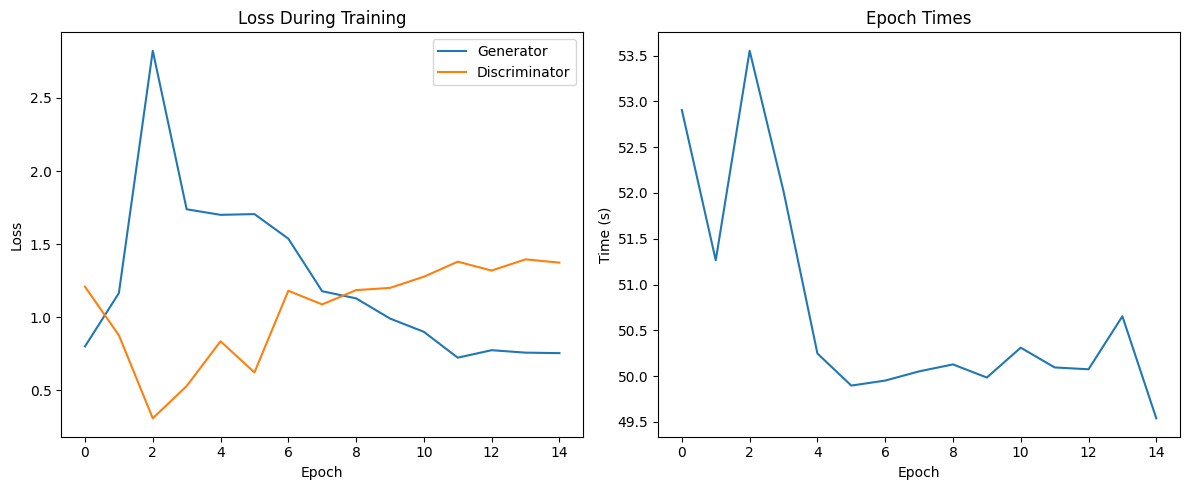

In [142]:
def load_pet_images_dataset():
    print("Загрузка датасета...")
    dataset_path = kagglehub.dataset_download("tanlikesmath/the-oxfordiiit-pet-dataset")
    images_dir = os.path.join(dataset_path, "images")
    print(f"Количество изображений в источнике: {len(os.listdir(images_dir))}")
    
    image_paths = []
    breed_labels = []
    species_labels = []
    breeds = set()
    processed_files = 0
    skipped_files = 0
    
    all_files = [f for f in os.listdir(images_dir) if f.lower().endswith('.jpg')]
    print(f"Найдено JPG файлов: {len(all_files)}")
    
    if len(all_files) > MAX_IMAGES:
        import random
        random.shuffle(all_files)
        selected_files = all_files[:MAX_IMAGES]
        print(f"Для ускорения обучения используем только {MAX_IMAGES} изображений")
    else:
        selected_files = all_files
    
    for filename in selected_files:
        file_path = os.path.join(images_dir, filename)
        if os.path.isdir(file_path):
            skipped_files += 1
            continue
    
        breed = getattr(re.match(r'^([A-Za-z_]+)_\d+\.jpg$', filename), 'group', lambda _: '')(1)
        species = get_species(filename)
    
        if breed is None or species is None:
            skipped_files += 1
            continue
    
        image_paths.append(file_path)
        breed_labels.append(breed)
        species_labels.append(species)
        breeds.add(breed)
        processed_files += 1
    
    print(f"Обработано {processed_files} файлов")
    print(f"Пропущено {skipped_files} файлов")
    
    def preprocess(path):
        try:
            img = tf.io.read_file(path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(tf.image.convert_image_dtype(img, tf.float32), [IMG_SIZE_GAN, IMG_SIZE_GAN])
            img = (img * 2) - 1
            return img
        except tf.errors.InvalidArgumentError:
            print(f"Ошибка чтения изображения: {path}")
            return tf.zeros([IMG_SIZE_GAN, IMG_SIZE_GAN, 3])
    
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.shuffle(BUFFER_SIZE_GAN).batch(BATCH_SIZE_GAN).prefetch(tf.data.AUTOTUNE)
    
    print(f"Датасет подготовлен: {len(image_paths)} изображений")
    
    for batch in dataset.take(1):
        print(f"Форма батча: {batch.shape}")
        break
    
    return dataset

dataset = load_pet_images_dataset()
visualize_real_images(dataset)
generator = train_gan(dataset)

print("Генерация финальных изображений...")

генерация финальных изображений

In [145]:
generated_images = generate_new_images(generator)
enhanced_images = enhance_and_upscale_images(generated_images, target_size=128)
print(f"Все результаты сохранены в директории: {GAN_STORAGE}")

Улучшение качества изображений и повышение разрешения до 128x128...
Улучшенные изображения сохранены в gan-results
Все результаты сохранены в директории: gan-results
